In [1]:
from diffusers import EulerAncestralDiscreteScheduler, DDIMScheduler, UNet2DModel, DDPMScheduler

In [2]:
from matfusion_jax.vis import display_image, display_svbrdf, show_svbrdf

In [3]:
import imageio.v3 as iio
import cv2
import numpy as np
import torch
from pathlib import Path

# Model Loading

In [4]:
device = 'cuda'

In [5]:
model = UNet2DModel.from_pretrained('./checkpoints/flash_v1_diffusers/').to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Input Loading

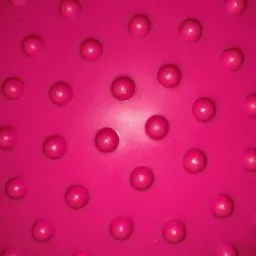

In [6]:
# TODO: pick your own image
# make sure it is linear RGB with a 2.2 gamma (roughly sRGB without tonemapping)
image = iio.imread('./demo/pink_input.png')
image = cv2.resize(image, (256, 256))
image = np.expand_dims(image, 0)
image = (image / 255.0) ** 2.2
display_image(image, 2.2)

In [7]:
# in addition to the input image itself, the flash finetuning expects the surface's halfway vector

def halfway_vectors(w, h, camera_pos, light_pos):
    surface = np.indices((h, w)) + 0.5
    surface = np.stack((
        2 * surface[1, :, :] / h - 1,
        -2 * surface[0, :, :] / w + 1,
        np.zeros((h, w), np.float32),
    ), axis=-1)

    wi = light_pos - surface
    wi /= np.linalg.norm(wi, axis=2, keepdims=True)

    wo = camera_pos - surface
    wo /= np.linalg.norm(wo, axis=2, keepdims=True)

    hw = wi + wo
    hw /= np.linalg.norm(hw, axis=2, keepdims=True)

    return hw

In [8]:
# accurate FOV can make a pretty big quality difference
fov = 45

distance = 1/np.tan(np.deg2rad([fov])/2)
hw = torch.tensor(
    halfway_vectors(*image.shape[1:3], [0, 0, distance.item()], [0, 0, distance.item()]),
    dtype=torch.float32,
    device=device,
).unsqueeze(0).permute(0, 3, 1, 2)

model_input = torch.tensor(image, device=device, dtype=torch.float32).permute(0, 3, 1, 2) * 2 - 1
model_input = torch.cat((model_input, hw), 1)

# Run MatFusion using Huggingface Diffusers

In [9]:
euler_a_schedule = EulerAncestralDiscreteScheduler(
    beta_schedule='linear',
    prediction_type='v_prediction',
    timestep_spacing="linspace",
)
ddim_schedule = DDIMScheduler(
    beta_schedule='linear',
    prediction_type='v_prediction',
    rescale_betas_zero_snr=True,
    clip_sample=False,
    timestep_spacing="linspace",
)
schedule = euler_a_schedule
schedule.set_timesteps(20)
timestep_mult = model.config.get('timestep_mult', 1/1000)

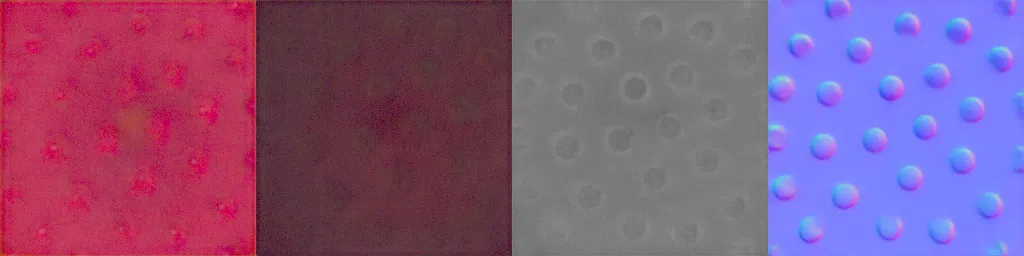

In [10]:
diffusion_frames = []

with torch.no_grad():
    y = torch.randn(1, 10, *model_input.shape[2:], device=device, dtype=torch.float32)
    y = y * schedule.init_noise_sigma

    for t in schedule.timesteps:
        noisy_svbrdf = schedule.scale_model_input(y, t)
        model_output = model(
            torch.cat((noisy_svbrdf, model_input), 1),
            t*timestep_mult,
        ).sample

        step_output = schedule.step(model_output, t, y)
        y = step_output.prev_sample

        svbrdf_est = (step_output.pred_original_sample * 0.5 + 0.5).clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy()
        diffusion_frames.append(svbrdf_est)

show_svbrdf(np.concatenate(diffusion_frames), horizontal=True, gamma=2.2)

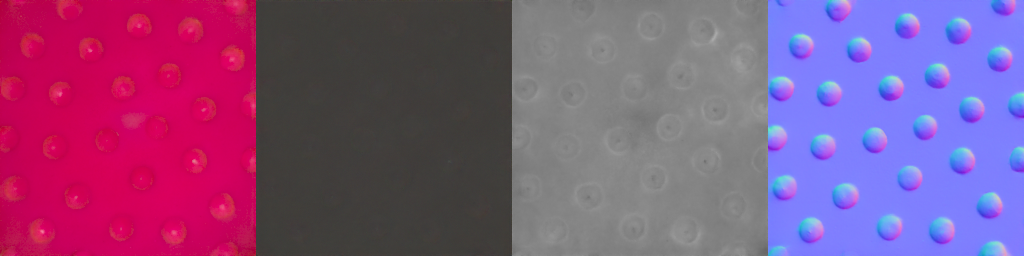

In [11]:
svbrdf_img = display_svbrdf(svbrdf_est[0], horizontal=True, format='png', gamma=2.2)
Path('./demo/pink_svbrdf.png').write_bytes(svbrdf_img.data) # optional: save the svbrdf to disk
svbrdf_img

# Run MatFusion using a basic DDIM sampler

t=999 a=0.0 b=1.0
t=946 a=0.0044 b=1.0
t=893 a=0.011 b=1.0
t=841 a=0.021 b=1.0
t=788 a=0.037 b=1.0
t=736 a=0.058 b=1.0
t=683 a=0.088 b=1.0
t=630 a=0.13 b=0.99
t=578 a=0.18 b=0.98
t=525 a=0.24 b=0.97
t=473 a=0.31 b=0.95
t=420 a=0.4 b=0.92
t=368 a=0.5 b=0.87
t=315 a=0.6 b=0.8
t=262 a=0.7 b=0.72
t=210 a=0.79 b=0.61
t=157 a=0.88 b=0.48
t=105 a=0.94 b=0.34
t=52 a=0.98 b=0.18
t=0 a=1.0 b=0.01


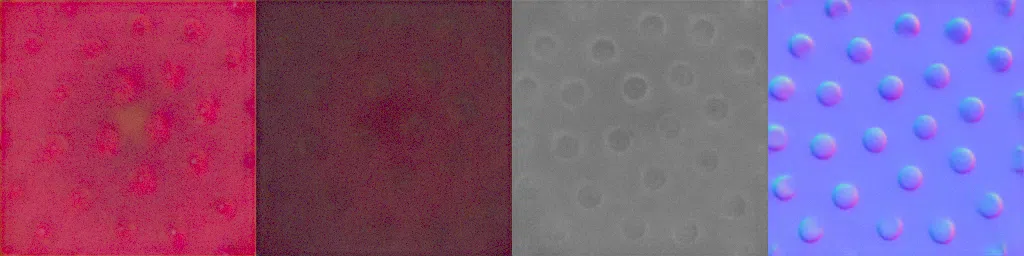

In [12]:
a_bar = ddim_schedule.alphas_cumprod.cpu().numpy()

timesteps = list(np.linspace(999, 0, 20, dtype=np.int64))

diffusion_frames = []

with torch.no_grad():
    signal = torch.zeros(1, 10, *model_input.shape[2:], device=device, dtype=torch.float32)
    noise = torch.randn_like(signal)

    for t in timesteps:
        # subscript 2 on page 3 of the MatFusion paper
        a = np.sqrt(a_bar[t])
        b = np.sqrt(1 - a_bar[t])

        print(f't={t} a={a:.2} b={b:.2}')

        y = a * signal + b * noise
        v_est = model(
            torch.cat((y, model_input), 1),
            torch.tensor(t*timestep_mult),
        ).sample

        # equation 4 page 3 of the MatFusion paper
        signal = a * y - b * v_est

        # equation 5 page 3 of the MatFusion paper
        noise = b * y + a * v_est

        svbrdf_est = (signal * 0.5 + 0.5).permute(0, 2, 3, 1).clamp(0, 1).cpu().numpy()
        diffusion_frames.append(svbrdf_est)

show_svbrdf(np.concatenate(diffusion_frames), horizontal=True, gamma=2.2)